In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import subprocess
import contexttimer
import numpy as np
import runlmc # just to check it's in PYTHONPATH
import sys

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', serif=['Palatino'])

def captured_run(*args):
    cmd = ['python3'] + list(map(str, args))
    proc = subprocess.run(cmd, stdout=subprocess.PIPE, universal_newlines=True)
    proc.check_returncode()
    return proc.stdout

def find_subarray_end(arr, sub):
    for i in range(len(arr) - len(sub)):
        end = i + len(sub)
        cmp = arr[i:end]
        if cmp == sub:
            return end
    return -1

def consume_float(arr, sub):
    i = find_subarray_end(arr, sub)
    assert i > 0, (i, arr, sub)
    assert i <= len(arr), (i, arr, sub)
    value = float(arr[i])
    return arr[i:], value

In [2]:
# Exact eigenvalues
n = 800
ds = list(range(1, 6))

def parse_eig(s):
    words = s.split()
    dense = ['dense', 'lapack', 'sec']
    kron = ['kron', 'decomp', 'sec']
    eigdiff = ['eigdiff']
    # returns a list with 3 items
    # for random, linear, and exponentially decreasing matrices
    # each list item is a list with 3 items
    # dense time, kron time, avg absolute error
    out = []
    for _ in range(3):
        words, dense_time = consume_float(words, dense)
        words, kron_time = consume_float(words, kron)
        words, diff = consume_float(words, eigdiff)
        out.append([dense_time, kron_time, diff])
    return out

random, poor, well = [], [], []
for d in ds:
    print('running eig n = {} d = {} exact'.format(n, d), end='')
    sys.stdout.flush()
    with contexttimer.Timer() as t:
        s = captured_run('eig.py', n, d, 1)
        r, p, w = parse_eig(s)
        random.append(r)
        poor.append(p)
        well.append(w)
    print(' tot time = {:8.4f} sec'.format(t.elapsed))
    
results_eig_exact = [np.array(x).T for x in (random, poor, well)]
random, poor, well = results_eig_exact

running eig n = 800 d = 1 exact tot time =   5.7410 sec
running eig n = 800 d = 2 exact tot time =  19.9917 sec
running eig n = 800 d = 3 exact tot time =  43.6042 sec
running eig n = 800 d = 4 exact tot time =  96.6756 sec
running eig n = 800 d = 5 exact tot time = 185.1422 sec


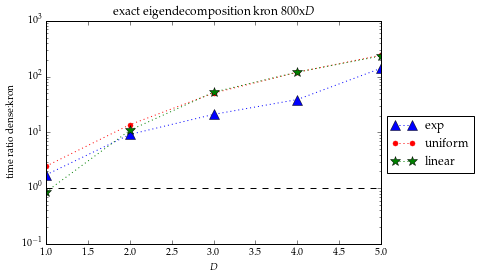

In [3]:
plt.semilogy(ds, well[0] / well[1], label='exp', c='b', marker='^', ls=':', ms=10)
plt.semilogy(ds, random[0] / random[1], label='uniform', c='r', marker='.', ls=':', ms=10)
plt.semilogy(ds, poor[0] / poor[1], label='linear', c='g', marker='*', ls=':', ms=10)
plt.axhline(y=1, c='black', ls='--')
plt.legend(bbox_to_anchor=(1, 0.6), loc=2)
plt.title(r'exact eigendecomposition kron {}x$D$'.format(n))
plt.xlabel(r'$D$')
plt.ylabel(r'time ratio dense:kron')
plt.show()

In [4]:
# avg abs err in eigenvalues (across all D)
well[2].mean(), random[2].mean(), poor[2].mean()

(3.6185415774880881e-15, 5.1138607237710688e-15, 1.0693169884279373e-12)

In [5]:
# Approx eigenvalues

random, poor, well = [], [], []
for d in ds:
    print('running eig n = {} d = {} approx'.format(n, d), end='')
    sys.stdout.flush()
    with contexttimer.Timer() as t:
        s = captured_run('eig.py', n, d, 0)
        r, p, w = parse_eig(s)
        random.append(r)
        poor.append(p)
        well.append(w)
    print(' tot time = {:8.4f} sec'.format(t.elapsed))
    
results_eig_approx = [np.array(x).T for x in (random, poor, well)]
random, poor, well = results_eig_approx

running eig n = 800 d = 1 approx tot time =   4.7894 sec
running eig n = 800 d = 2 approx tot time =  14.8824 sec
running eig n = 800 d = 3 approx tot time =  43.4806 sec
running eig n = 800 d = 4 approx tot time =  96.0211 sec
running eig n = 800 d = 5 approx tot time = 180.1582 sec


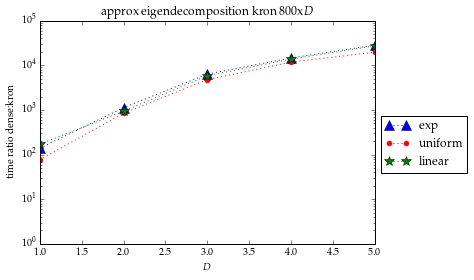

In [6]:
plt.semilogy(ds, well[0] / well[1], label='exp', c='b', marker='^', ls=':', ms=10)
plt.semilogy(ds, random[0] / random[1], label='uniform', c='r', marker='.', ls=':', ms=10)
plt.semilogy(ds, poor[0] / poor[1], label='linear', c='g', marker='*', ls=':', ms=10)
plt.axhline(y=1, c='black', ls='--')
plt.legend(bbox_to_anchor=(1, 0.6), loc=2)
plt.title(r'approx eigendecomposition kron {}x$D$'.format(n))
plt.xlabel(r'$D$')
plt.ylabel(r'time ratio dense:kron')
plt.show()

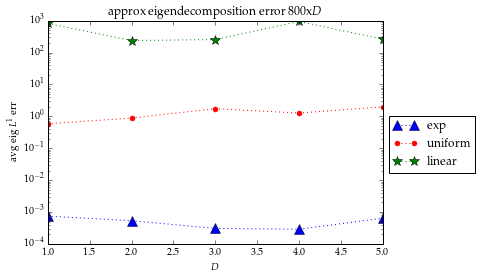

In [7]:
plt.semilogy(ds, well[2], label='exp', c='b', marker='^', ls=':', ms=10)
plt.semilogy(ds, random[2], label='uniform', c='r', marker='.', ls=':', ms=10)
plt.semilogy(ds, poor[2], label='linear', c='g', marker='*', ls=':', ms=10)
plt.legend(bbox_to_anchor=(1, 0.6), loc=2)
plt.title(r'approx eigendecomposition error {}x$D$'.format(n))
plt.xlabel(r'$D$')
plt.ylabel(r'avg eig $L^1$ err')
plt.show()

In [60]:
def parse_inversion(s):
    words = s.split()
    dense = ['linear', 'solve', 'sec']
    cg = ['sparse', 'CG', 'sec']
    minres = ['sparse', 'MINRES', 'sec']
    out = [[], [], []]
    for _ in range(3):
        words, dense_time = consume_float(words, dense)
        words, cg_time = consume_float(words, cg)
        words, minres_time = consume_float(words, minres)
        for i, val in enumerate([dense_time, cg_time, minres_time]):
            out[i].append(val)
    return out

more_ds = list(range(1, 9))

dense, cg, minres = [], [], []
for d in more_ds:
    print('running inversion n = {} d = {} approx'.format(n, d), end='')
    sys.stdout.flush()
    with contexttimer.Timer() as t:
        s = captured_run('inversion.py', n, d, 3, 1e-3)
        d, c, m = parse_inversion(s)
        dense.append(d)
        cg.append(c)
        minres.append(m)
    print(' tot time = {:8.4f} sec'.format(t.elapsed))
    
results_inversion_modd = [np.array(x).T for x in (dense, cg, minres)]
dense, cg, minres = results_inversion_modd

running inversion n = 800 d = 1 approx tot time =  15.2530 sec
running inversion n = 800 d = 2 approx tot time =  37.2250 sec
running inversion n = 800 d = 3 approx tot time =  59.6815 sec
running inversion n = 800 d = 4 approx tot time = 102.2060 sec
running inversion n = 800 d = 5 approx tot time = 176.7914 sec
running inversion n = 800 d = 6 approx tot time = 297.0857 sec
running inversion n = 800 d = 7 approx tot time = 509.4544 sec
running inversion n = 800 d = 8 approx tot time = 689.1272 sec


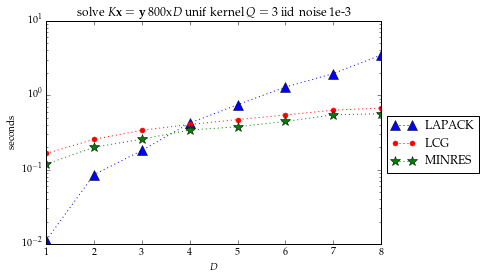

In [61]:
plt.semilogy(more_ds, dense[0], label='LAPACK', c='b', marker='^', ls=':', ms=10)
plt.semilogy(more_ds, cg[0], label='LCG', c='r', marker='.', ls=':', ms=10)
plt.semilogy(more_ds, minres[0], label='MINRES', c='g', marker='*', ls=':', ms=10)
plt.legend(bbox_to_anchor=(1, 0.6), loc=2)
plt.title(r'solve $K\textbf{{x}}=\textbf{{y}}$ {}x$D$ unif kernel $Q=3$ iid noise 1e-3'.format(n))
plt.xlabel(r'$D$')
plt.ylabel('seconds')
plt.show()

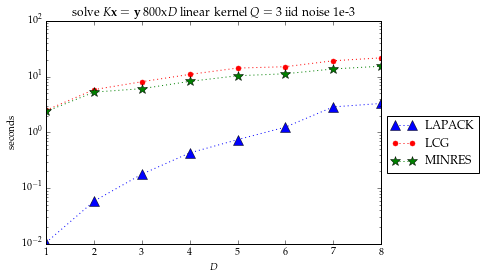

In [62]:
plt.semilogy(more_ds, dense[1], label='LAPACK', c='b', marker='^', ls=':', ms=10)
plt.semilogy(more_ds, cg[1], label='LCG', c='r', marker='.', ls=':', ms=10)
plt.semilogy(more_ds, minres[1], label='MINRES', c='g', marker='*', ls=':', ms=10)
plt.legend(bbox_to_anchor=(1, 0.6), loc=2)
plt.title(r'solve $K\textbf{{x}}=\textbf{{y}}$  {}x$D$ linear kernel $Q=3$ iid noise 1e-3'.format(n))
plt.xlabel(r'$D$')
plt.ylabel('seconds')
plt.show()

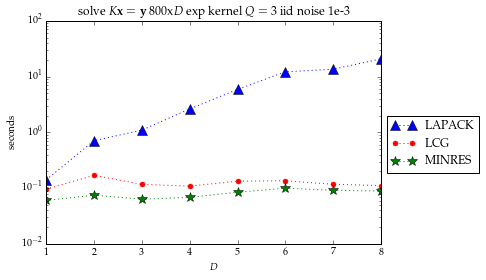

In [63]:
plt.semilogy(more_ds, dense[2], label='LAPACK', c='b', marker='^', ls=':', ms=10)
plt.semilogy(more_ds, cg[2], label='LCG', c='r', marker='.', ls=':', ms=10)
plt.semilogy(more_ds, minres[2], label='MINRES', c='g', marker='*', ls=':', ms=10)
plt.legend(bbox_to_anchor=(1, 0.6), loc=2)
plt.title(r'solve $K\textbf{{x}}=\textbf{{y}}$ {}x$D$ exp kernel $Q=3$ iid noise 1e-3'.format(n))
plt.xlabel(r'$D$')
plt.ylabel('seconds')
plt.show()

In [57]:
def parse_logdet(s):
    words = s.split()
    dense = ['dense', 'lapack', 'sec']
    approx = ['logdetsum', 'sec']
    rele = ['relative', 'error']
    out = [[], [], []]
    for _ in range(3):
        words, dense_time = consume_float(words, dense)
        words, approx_time = consume_float(words, approx)
        words, rel_err = consume_float(words, rele)
        for i, val in enumerate([dense_time, approx_time, rel_err]):
            out[i].append(val)
    return out

dense, approx, rel_err = [], [], []
for d in ds:
    print('running logdet n = {} d = {} approx'.format(n, d), end='')
    sys.stdout.flush()
    with contexttimer.Timer() as t:
        s = captured_run('logdet.py', n, d, 3, 1e-3)
        d, a, r = (np.array(x) for x in parse_logdet(s))
        dense.append(d)
        approx.append(a)
        rel_err.append(r)
    print(' tot time = {:8.4f} sec'.format(t.elapsed))
    
results_logdet = [np.array(x).T for x in (dense, approx, rel_err)]
dense, approx, rel_err = results_logdet

running logdet n = 800 d = 1 approx tot time =  10.0543 sec
running logdet n = 800 d = 2 approx tot time =  15.5197 sec
running logdet n = 800 d = 3 approx tot time =  27.6168 sec
running logdet n = 800 d = 4 approx tot time =  48.2968 sec
running logdet n = 800 d = 5 approx tot time = 103.3087 sec


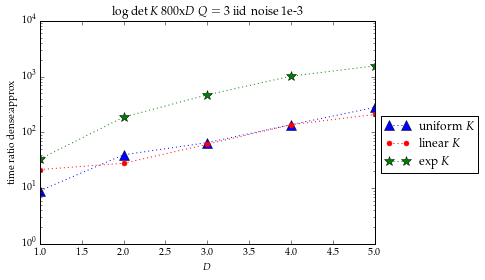

In [58]:
plt.semilogy(ds, dense[0] / approx[0], label=r'uniform $K$', c='b', marker='^', ls=':', ms=10)
plt.semilogy(ds, dense[1] / approx[1], label=r'linear $K$', c='r', marker='.', ls=':', ms=10)
plt.semilogy(ds, dense[2] / approx[2], label=r'exp $K$', c='g', marker='*', ls=':', ms=10)
plt.axhline(y=1, c='black', ls='--')
plt.legend(bbox_to_anchor=(1, 0.6), loc=2)
plt.title(r'$\log\det K$ {}x$D$ $Q=3$ iid noise 1e-3'.format(n))
plt.xlabel(r'$D$')
plt.ylabel('time ratio dense:approx')
plt.show()

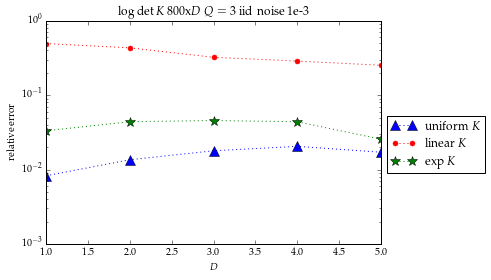

In [59]:
plt.semilogy(ds, rel_err[0], label=r'uniform $K$', c='b', marker='^', ls=':', ms=10)
plt.semilogy(ds, rel_err[1], label=r'linear $K$', c='r', marker='.', ls=':', ms=10)
plt.semilogy(ds, rel_err[2], label=r'exp $K$', c='g', marker='*', ls=':', ms=10)
plt.legend(bbox_to_anchor=(1, 0.6), loc=2)
plt.axhline(y=1, c='black', ls='--')
plt.title(r'$\log\det K$ {}x$D$ $Q=3$ iid noise 1e-3'.format(n))
plt.xlabel(r'$D$')
plt.ylabel('relative error')
plt.show()